In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf


data = yf.download("SPY", start="2015-01-01", end="2024-12-31")["Close"].resample("ME").last()
print(data.head())

[*********************100%***********************]  1 of 1 completed

1 Failed download:
['SPY']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Empty DataFrame
Columns: [SPY]
Index: []


Ticker           SPY
Date                
2015-02-28  0.054682
2015-03-31 -0.015830
2015-04-30  0.009786
2015-05-31  0.012774
2015-06-30 -0.020522
Ticker           SPY
Date                
2015-02-28  0.002990
2015-03-31  0.000251
2015-04-30  0.000096
2015-05-31  0.000163
2015-06-30  0.000421


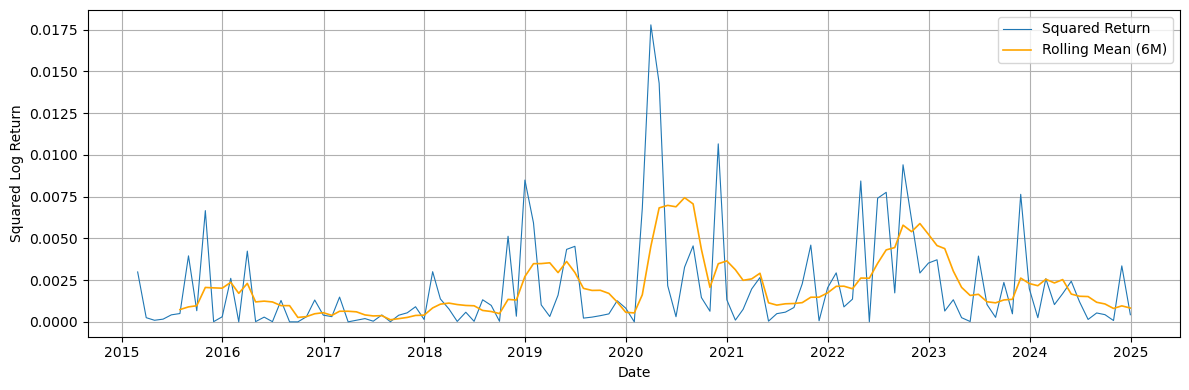

In [34]:
# Beregn log-afkast
log_returns = np.log(data / data.shift(1)).dropna()
squared_returns = log_returns**2


print(log_returns.head())
print(squared_returns.head())

df = squared_returns.reset_index()
df.columns = ['Date', 'Squared Return']
df['Rolling Mean (6M)'] = df['Squared Return'].rolling(window=6).mean()

plt.figure(figsize=(12, 4))
plt.plot(df['Date'], df['Squared Return'], label='Squared Return', linewidth=0.8)
plt.plot(df['Date'], df['Rolling Mean (6M)'], label='Rolling Mean (6M)', color='orange', linewidth=1.2)
# plt.title("Squared Monthly Log Returns (SPY) with 6-Month Average")
plt.xlabel("Date")
plt.ylabel("Squared Log Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()





In [ ]:
# Variance range
v = np.linspace(0, 50, 100)

# Black–Scholes constant-vol boundary
S_BS = 100
S_bs_line = S_BS * np.ones_like(v)

# Heston exercise surfaces for rho = -0.5 and rho = +0.5
rho_neg = -0.5
rho_pos = 0.5

S_neg = S_BS + rho_neg * v  # downward slope for negative rho
S_pos = S_BS + rho_pos * v  # upward slope for positive rho

# Plot
plt.figure()
plt.plot(v, S_neg, label=r'$\rho = -0.5$')
plt.plot(v, S_pos, label=r'$\rho = +0.5$')
plt.plot(v, S_bs_line, linestyle='--', label='Black–Scholes $S^*_{BS}$')
plt.xlabel('Variance $v$')
plt.ylabel('Exercise Boundary $S^*(t, v)$')
plt.title('Comparative Statics of $S^*(t,v)$ vs. Variance')
plt.legend()
plt.grid(True)
plt.show()


In [9]:
import numpy as np
import pandas as pd
from numpy.linalg import lstsq

def lsm_american_put_bs(S0, K, r, sigma, T, M, N):
    dt = T / N
    # simulate asset paths
    S = np.zeros((M, N+1))
    S[:, 0] = S0
    for t in range(1, N+1):
        Z = np.random.normal(size=M)
        S[:, t] = S[:, t-1] * np.exp((r - 0.5*sigma**2)*dt + sigma*np.sqrt(dt)*Z)
    
    # payoff matrix
    payoff = np.maximum(K - S, 0)
    # initialize cashflows with terminal payoff
    cashflows = payoff[:, -1]
    
    # backward induction
    for t in range(N-1, 0, -1):
        itm = payoff[:, t] > 0  # in-the-money paths
        if np.any(itm):
            # basis functions
            x = S[itm, t] / K
            X = np.vstack([np.ones_like(x), 1-x, 1-2*x+0.5*x**2]).T
            # regression of discounted cashflows
            Y = np.exp(-r*dt) * cashflows[itm]
            coeffs, _, _, _ = lstsq(X, Y, rcond=None)
            cont_val = X.dot(coeffs)
            # exercise decision
            exercise = payoff[itm, t] > cont_val
            # update cashflows: if exercise, use current payoff; else discount continuation
            cashflows[itm] = np.where(exercise, payoff[itm, t], cashflows[itm]*np.exp(-r*dt))
    
    # price estimate and standard error
    price = np.mean(cashflows * np.exp(-r*dt))  # discount first step
    stderr = np.std(cashflows * np.exp(-r*dt)) / np.sqrt(M)
    return price, stderr

# parameters
S0 = 100
K = 100
r = 0.05
sigma = 0.2
T = 1.0
M = 50000  # number of paths
Ns = [25, 50, 100]

results = []
for N in Ns:
    price, stderr = lsm_american_put_bs(S0, K, r, sigma, T, M, N)
    results.append({"N": N, "Price": price, "StdError": stderr})

print(pd.DataFrame(results))


     N     Price  StdError
0   25  6.142372  0.032988
1   50  6.083157  0.032450
2  100  6.109847  0.031775
